In [1]:
!pip install norse nir nirtorch torch torchvision snntorch tonic matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 296.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/

# CAUTION
If you are using google collab restart kernel session due to numpy error
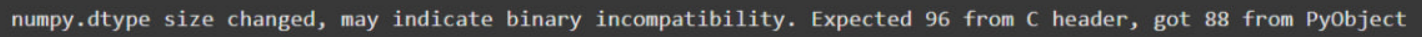

##Norse Nmnist Classifier

In [1]:
import torch
import norse


model = norse.torch.SequentialState(
    norse.torch.LIFBoxCell(),
    torch.nn.Conv2d(2, 8, 3),
    torch.nn.MaxPool2d(2),
    norse.torch.LIFBoxCell(),
    torch.nn.Conv2d(8, 16, 3),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(1),
    torch.nn.Linear(784,10)
)

model(torch.empty(1, 2, 34, 34))[0].shape


torch.Size([1, 10])

In [2]:
nir_graph = norse.torch.to_nir(model, torch.empty(1, 2, 34, 34))
nir_graph.nodes.keys()

dict_keys(['input', '0', '1', '2', '3', '4', '5', '6', '7', 'output'])

In [3]:
import tonic
from torch.utils.data import DataLoader
from tqdm import tqdm

to_frame = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size,
    time_window=1e3
)

train_dataset = tonic.datasets.NMNIST(
    save_to=".",
    train=True,
    transform=to_frame
)

test_dataset = tonic.datasets.NMNIST(
    save_to=".",
    train=False,
    transform=to_frame,
)

# DataLoaders
BATCH_SIZE = 10
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,collate_fn=tonic.collation.PadTensors())

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=tonic.collation.PadTensors())

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./NMNIST/train.zip to ./NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./NMNIST/test.zip to ./NMNIST


In [4]:
train_dataset[0][0].shape

(304, 2, 34, 34)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")

CUDA is available. Using GPU.


In [7]:
model.to(device)

SequentialState(
  (0): LIFBoxCell(p=LIFBoxParameters(tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.), reset_method=<function reset_value at 0x7ca64a548720>), dt=0.001)
  (1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): LIFBoxCell(p=LIFBoxParameters(tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.), reset_method=<function reset_value at 0x7ca64a548720>), dt=0.001)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=784, out_features=10, bias=True)
)

In [9]:
def train(model, train_loader, epochs=2):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, targets in tqdm(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            # Reshape data: (batch_size, time_steps, channels, height, width) -> (batch_size, channels, height, width) caution!!!
            data = data.mean(dim=1)

            # Forward
            outputs, _ = model(data)
            loss = criterion(outputs, targets)

            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Train the model
train(model, train_loader, epochs=3)

100%|██████████| 6000/6000 [05:30<00:00, 18.17it/s]


Epoch 1, Loss: 2.3023624125321707


100%|██████████| 6000/6000 [05:32<00:00, 18.02it/s]


Epoch 2, Loss: 2.302494749903679


100%|██████████| 6000/6000 [05:30<00:00, 18.17it/s]

Epoch 3, Loss: 2.3023122259378432


#Model test dataset


In [13]:
!pip install scikit-learn

In [17]:
from sklearn.metrics import classification_report

def test(model, test_loader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, targets in tqdm(test_loader):
            data = data.to(device)
            targets = targets.to(device)

            data = data.mean(dim=1)
            outputs, _ = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Print test results
    print(f"Test Loss: {total_loss / len(test_loader)}")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_targets, all_predictions))

test(model, test_loader)

100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


Test Loss: 2.302647028684616
Test Accuracy: 10.28%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.10      1.00      0.19      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
nir_model = norse.torch.to_nir(model, torch.empty(1 ,2, 34, 34).to(device))

In [27]:
import nir

nir.write("nir_model.nir", nir_model)

AttributeError: 'NoneType' object has no attribute 'to_dict'

# Testing on SnnTorch

In [30]:
import snntorch as snn

# Load the NIR model from file
nir_model = nir.read("nir_model.nir")

# Reconstruct the model in snnTorch
def reconstruct_model_from_nir(nir_model):
    layers = []
    for node in nir_model.nodes:
        if isinstance(node, nir.LIF):
            # Reconstruct LIF layer
            layers.append(
                snn.Leaky(
                    beta=node.tau_mem_inv,  # Inverse time constant
                    threshold=node.v_threshold,  # Threshold voltage
                    reset_mechanism="subtract",  # Reset mechanism
                )
            )
        elif isinstance(node, nir.Affine):
            # Reconstruct Linear layer
            layers.append(
                torch.nn.Linear(
                    in_features=node.weight.shape[1],
                    out_features=node.weight.shape[0],
                )
            )
            # Set weights and biases
            layers[-1].weight.data = torch.tensor(node.weight)
            layers[-1].bias.data = torch.tensor(node.bias)
        elif isinstance(node, nir.Conv2d):
            # Reconstruct Conv2d layer
            layers.append(
                torch.nn.Conv2d(
                    in_channels=node.weight.shape[1],
                    out_channels=node.weight.shape[0],
                    kernel_size=node.kernel_size,
                    stride=node.stride,
                    padding=node.padding,
                )
            )
            # Set weights and biases
            layers[-1].weight.data = torch.tensor(node.weight)
            layers[-1].bias.data = torch.tensor(node.bias)
        else:
            raise ValueError(f"Unsupported NIR node type: {type(node)}")

    return torch.nn.Sequential(*layers)

# Reconstruct the model
model = reconstruct_model_from_nir(nir_model)
print(model)

ValueError: Unsupported NIR node type: <class 'str'>